In [16]:
#import libraries for data preprocessing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn import preprocessing
from operator import itemgetter
from sklearn.metrics import mean_absolute_error
import keras
import seaborn as sns

In [17]:
#read, manipulate and display stock data
df=pd.read_csv("https://raw.githubusercontent.com/ashishpatel26/NYSE-STOCK_MARKET-ANALYSIS-USING-LSTM/master/nyse/prices-split-adjusted.csv",index_col=0)
df['adj close']=df.close #create a new column called adj close 
df.drop(['close'],axis=1,inplace=True) #drop the close column
df.head()

,symbol,open,low,high,volume,adj close
date,,,,,,
2016-01-05,WLTW,123.430000,122.309998,126.250000,2163600.0,125.839996
2016-01-06,WLTW,125.239998,119.940002,125.540001,2386400.0,119.980003
2016-01-07,WLTW,116.379997,114.930000,119.739998,2489500.0,114.949997
2016-01-08,WLTW,115.480003,113.500000,117.440002,2006300.0,116.620003
2016-01-11,WLTW,117.010002,114.089996,117.330002,1408600.0,114.970001


In [18]:
#find unique symbols in a dataframe
symbols = list(df.symbol.unique())
len(symbols)

501

In [19]:
#select the first 11 elements
symbols[:11]

['WLTW', 'A', 'AAL', 'AAP', 'AAPL', 'ABC', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADM']

In [20]:
#select and drop symbol column for GOOG
df=df[df.symbol == 'GOOG']
df.drop(['symbol'],axis=1,inplace=True)
df.head()

,open,low,high,volume,adj close
date,,,,,
2010-01-04,312.304948,310.955001,313.580158,3927000.0,312.205308
2010-01-05,312.419511,309.610028,312.748278,6031900.0,310.830459
2010-01-06,311.761979,302.048370,311.761979,7987100.0,302.994813
2010-01-07,303.562685,295.218951,303.861575,12876600.0,295.941242
2010-01-08,294.895159,293.455551,300.499172,9483900.0,299.886470


In [21]:
#summarizes dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       1762 non-null   float64
 1   low        1762 non-null   float64
 2   high       1762 non-null   float64
 3   volume     1762 non-null   float64
 4   adj close  1762 non-null   float64
dtypes: float64(5)
memory usage: 82.6+ KB


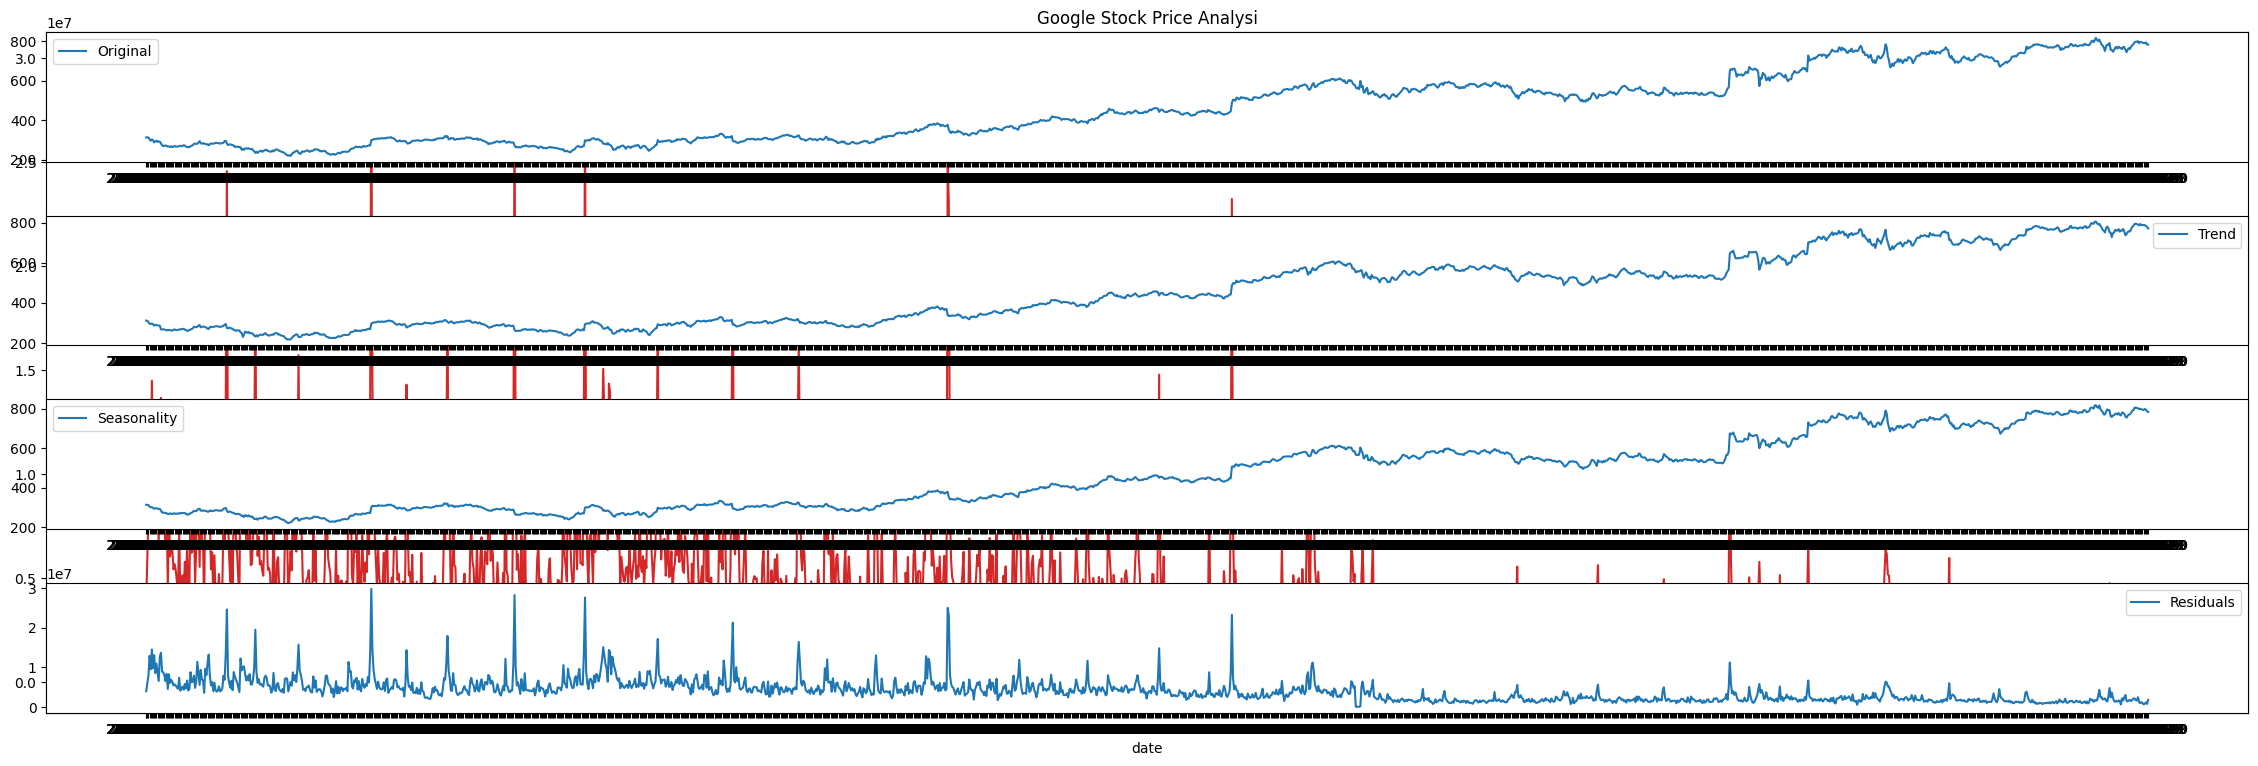

In [22]:
#plot Google stock price analysis
df.plot(figsize=(23,8),title="Google Stock Price Analysi")
plt.subplot(411)
plt.plot(df.open, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(df.low, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(df.high, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(df.volume, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

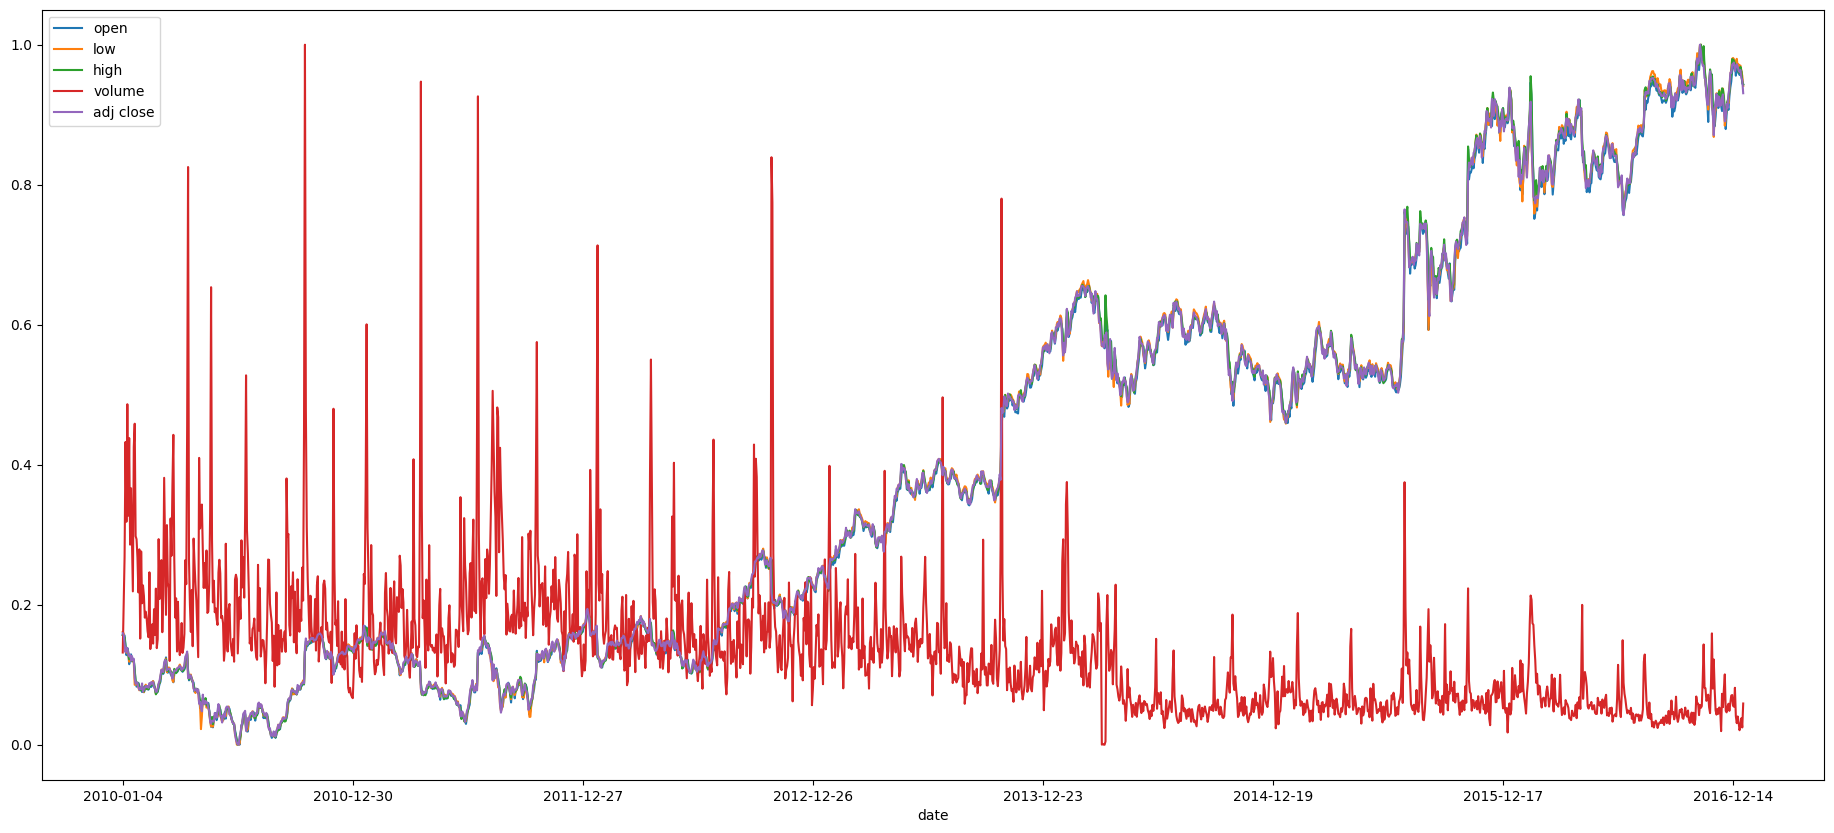

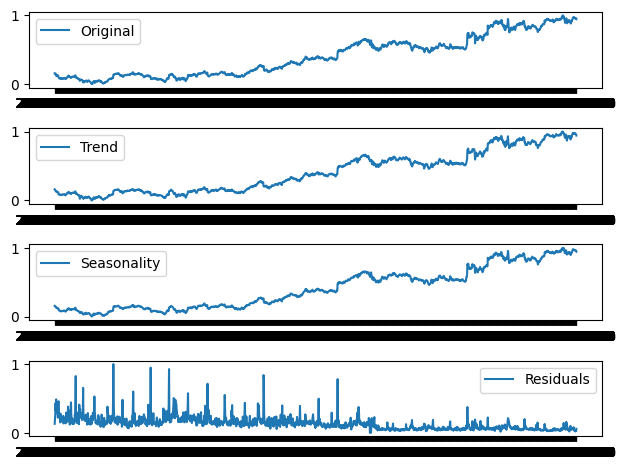

In [23]:
#Normalize stock data for plotting
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    df['adj close'] = min_max_scaler.fit_transform(df['adj close'].values.reshape(-1,1))

    return df
df=normalize_data(df)
df.plot(figsize=(23,10))
plt.show()
plt.subplot(411)
plt.plot(df.open, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(df.low, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(df.high, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(df.volume, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [24]:
del df['volume']

In [25]:
df.head()

,open,low,high,adj close
date,,,,
2010-01-04,0.157047,0.161167,0.156390,0.159399
2010-01-05,0.157238,0.158884,0.154995,0.157092
2010-01-06,0.156140,0.146049,0.153341,0.143942
2010-01-07,0.142436,0.134457,0.140094,0.132105
2010-01-08,0.127950,0.131464,0.134455,0.138726


In [27]:
#remove column, load stock data with windowing
#del df['volume']
def load_data(stock, window):
    data=stock.to_numpy()
    result = []

    for index in range (len(data)-window):
        result.append(data[index: index + window])
    result=np.array(result).reshape(4*window, -1)
    row=round(0.9 * result.shape[1])

    x_train=result[:, :int(row)]
    y_train= data[window:window+int(row),3].reshape(-1,1)

    x_test=result[:, int(row):]
    y_test= data[window+int(row):,3].reshape(-1,1)
    return [x_train, y_train, x_test, y_test]

In [28]:
#load the training and testing data
x_train, y_train, x_test, y_test =load_data(df.iloc[:1760,:],10)

In [29]:
x_train.shape
y_train.shape

(1575, 1)

In [49]:
#import tensorflow and keras components
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [51]:
stock=df.iloc[:1760,:]
window=10
data=stock.to_numpy()
result=[]

for index in range(len(data)-window):
    result.append(data[index: index + window])
result=np.array(result).reshape(4*window, -1)
x=result.T
y=data[window:,3]
print(x.shape)
print(y.shape)

(1750, 40)
(1750,)


In [52]:
x=x.reshape(x.shape[0],x.shape[1],1)
print(x.shape)

(1750, 40, 1)


In [47]:
#compile model
model.compile(loss='mse', optimizer=optimizers.SGD(learning_rate=0.01), metrics=['accuracy'])

In [53]:
#train the model with the data
x_train_cnn, x_test_cnn,y_train_cnn, y_test_cnn=train_test_split(x,y,test_size=0.1)
print(x_train_cnn.shape)
print(x_test_cnn.shape)
print(y_train_cnn.shape)
print(y_test_cnn.shape)

(1575, 40, 1)
(175, 40, 1)
(1575,)
(175,)


In [54]:
model=Sequential()
model.add(Conv1D(32,2, activation="relu", input_shape=(40,1)))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 39, 32)            96        
                                                                 
 flatten (Flatten)           (None, 1248)              0         
                                                                 
 dense_16 (Dense)            (None, 64)                79936     
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 80097 (312.88 KB)
Trainable params: 80097 (312.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
model.compile(loss="mse",optimizer="adam")

In [56]:
hist=model.fit(x_train_cnn,y_train_cnn,batch_size=12,epochs=100, validation_data=(x_test_cnn,y_test_cnn))

Epoch 1/100
132/132 [==============================] - 7s 41ms/step - loss: 0.0368 - val_loss: 0.0073
Epoch 2/100
132/132 [==============================] - 1s 7ms/step - loss: 0.0078 - val_loss: 0.0061
Epoch 3/100
132/132 [==============================] - 1s 5ms/step - loss: 0.0073 - val_loss: 0.0076
Epoch 4/100
132/132 [==============================] - 1s 5ms/step - loss: 0.0063 - val_loss: 0.0050
Epoch 5/100
132/132 [==============================] - 1s 5ms/step - loss: 0.0062 - val_loss: 0.0077
Epoch 6/100
132/132 [==============================] - 1s 10ms/step - loss: 0.0061 - val_loss: 0.0048
Epoch 7/100
132/132 [==============================] - 1s 7ms/step - loss: 0.0052 - val_loss: 0.0036
Epoch 8/100
132/132 [==============================] - 1s 9ms/step - loss: 0.0051 - val_loss: 0.0037
Epoch 9/100
132/132 [==============================] - 2s 13ms/step - loss: 0.0048 - val_loss: 0.0076
Epoch 10/100
132/132 [==============================] - 2s 17ms/step - loss: 0.0047 - va

In [57]:
#generate predictions using the CNN model
y_pred_cnn=model.predict(x_test_cnn)

6/6 [==============================] - 0s 7ms/step


50/50 [==============================] - 0s 4ms/step - loss: 0.0024
0.0024286373518407345
MSE: 0.0022


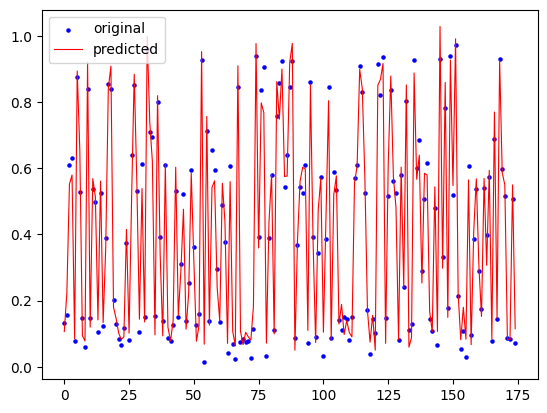

In [58]:
print(model.evaluate(x_train_cnn, y_train_cnn))
 
print("MSE: %.4f" % mean_squared_error(y_test_cnn, y_pred_cnn))
x_ax = range(len(y_pred_cnn))
plt.scatter(x_ax, y_test_cnn, s=5, color="blue", label="original")
plt.plot(x_ax, y_pred_cnn, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()